# Data Exploration

In [5]:
import numpy as np
import pandas as pd, json, pathlib
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
import torchvision
import torch, torch.optim as optim
import torch.nn.functional as F
# from focal_loss.focal_loss import FocalLoss
from PIL import Image
from pathlib import Path
import pickle
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support
from collections import Counter
import math
import torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd, numpy as np, random, math
from torch.utils.data import DataLoader, Dataset, TensorDataset
from imblearn.over_sampling import SMOTE
import os, math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from datetime import datetime
import json
from dataclasses import dataclass, asdict
import time

In [6]:
ROOT = Path.cwd().parent          # if you're running from notebooks/
DATA = ROOT / 'data'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/SET Project/LSWMD.pkl")

In [9]:
df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

In [10]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

In [11]:
if 'waferIndex' in df.columns:
    df = df.drop(['waferIndex'], axis=1)
else:
    print("Column 'waferIndex' does not exist in the DataFrame.")

In [12]:
df.info() #dataset check.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   waferMapDim     811457 non-null  object 
dtypes: float64(1), object(5)
memory usage: 37.1+ MB


In [13]:
df.head()

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [14]:
df.tail()

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,[],[],"(26, 30)"
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,[],[],"(26, 30)"


In [15]:
def extract_clean_label(failure_type):
    """
    Bulletproof function to extract clean string from any nested structure
    """
    # Handle None/NaN/empty string
    if pd.isna(failure_type) or failure_type is None or failure_type == '':
        return 'unlabeled'

    # If already a string, return as-is
    if isinstance(failure_type, str):
        return failure_type

    # If not a list, convert to string
    if not isinstance(failure_type, (list, np.ndarray)):
        return str(failure_type)

    # Handle empty list/array
    if len(failure_type) == 0:
        return 'unlabeled'

    # Recursively extract from nested lists - with safety check
    current = failure_type
    max_depth = 10  # Prevent infinite loops
    depth = 0

    while isinstance(current, (list, np.ndarray)) and len(current) > 0 and depth < max_depth:
        current = current[0]
        depth += 1

    # Handle case where we end up with empty or None after unwrapping
    if pd.isna(current) or current is None or current == '' or \
       (isinstance(current, (list, np.ndarray)) and len(current) == 0):
        return 'unlabeled'

    return str(current)

In [16]:
def clean_failure_types(df):
    """
    Complete solution to clean the failureType column
    """
    print("=== DEBUGGING FAILURE TYPE CLEANING ===")

    # Step 1: Check what we're starting with
    print(f"Original column dtype: {df['failureType'].dtype}")
    print(f"Sample values (first 5):")
    for i in range(min(5, len(df))):
        val = df.iloc[i]['failureType']
        print(f"  [{i}] {type(val).__name__}: {repr(val)}")

    # Step 2: Apply cleaning with explicit copy to avoid view issues
    df = df.copy()  # Ensure we're working with a full copy

    print(f"\nApplying cleaning function...")
    df['failureType_clean'] = df['failureType'].apply(extract_clean_label)

    # Step 3: Verify the cleaning worked
    print(f"After cleaning:")
    print(f"  New column dtype: {df['failureType_clean'].dtype}")
    print(f"  Unique values: {sorted(df['failureType_clean'].unique())}")
    print(f"  Value counts:")
    print(df['failureType_clean'].value_counts())

    # Step 4: Replace the original column
    df['failureType'] = df['failureType_clean']
    df.drop('failureType_clean', axis=1, inplace=True)

    # Step 5: Create numeric mapping
    mapping_type = {
        'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
        'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8,
        'unlabeled': 9  # Add this for safety
    }

    df['failureNum'] = df['failureType'].map(mapping_type)

    # Check for unmapped values
    unmapped = df[df['failureNum'].isna()]
    if len(unmapped) > 0:
        print(f"\nWARNING: {len(unmapped)} unmapped values found:")
        print(unmapped['failureType'].unique())
        # Fill unmapped with a default value
        df['failureNum'] = df['failureNum'].fillna(9)  # Treat as unlabeled

    print(f"\nFinal failureNum distribution:")
    print(df['failureNum'].value_counts().sort_index())

    return df

In [17]:
# Clean the failure types
df_clean = clean_failure_types(df)
df_clean['failureType'] = df_clean['failureType'].replace('Near-full', 'Near-Full')

=== DEBUGGING FAILURE TYPE CLEANING ===
Original column dtype: object
Sample values (first 5):
  [0] ndarray: array([['none']], dtype='<U4')
  [1] ndarray: array([['none']], dtype='<U4')
  [2] ndarray: array([['none']], dtype='<U4')
  [3] ndarray: array([['none']], dtype='<U4')
  [4] ndarray: array([['none']], dtype='<U4')

Applying cleaning function...


/tmp/ipython-input-3984346828.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.isna(failure_type) or failure_type is None or failure_type == '':


After cleaning:
  New column dtype: object
  Unique values: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none', 'unlabeled']
  Value counts:
failureType_clean
unlabeled    638507
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64

Final failureNum distribution:
failureNum
0      4294
1       555
2      5189
3      9680
4      3593
5       866
6      1193
7       149
8    147431
9    638507
Name: count, dtype: int64


In [18]:
def create_balanced_splits(df):
    """
    Create properly balanced train/val/test splits
    """
    print("\n=== CREATING SPLITS ===")

    # Only use labeled data (exclude 'unlabeled')
    df_labeled = df[df['failureType'] != 'unlabeled'].copy().reset_index(drop=True)
    print(f"Total labeled samples: {len(df_labeled)}")

    # Split into pattern vs non-pattern
    df_withpattern = df_labeled[df_labeled['failureType'] != 'none'].copy().reset_index(drop=True)
    df_nonpattern = df_labeled[df_labeled['failureType'] == 'none'].copy().reset_index(drop=True)

    print(f"With pattern: {len(df_withpattern)}")
    print(f"Without pattern (none): {len(df_nonpattern)}")
    print(f"Verification: {len(df_withpattern) + len(df_nonpattern)} = {len(df_labeled)}")

    # Show pattern distribution
    if len(df_withpattern) > 0:
        print(f"\nPattern type distribution:")
        print(df_withpattern['failureType'].value_counts())

    return df_labeled, df_withpattern, df_nonpattern


In [19]:
# Create splits
df_labeled, df_withpattern, df_nonpattern = create_balanced_splits(df_clean)


=== CREATING SPLITS ===
Total labeled samples: 172950
With pattern: 25519
Without pattern (none): 147431
Verification: 172950 = 172950

Pattern type distribution:
failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-Full     149
Name: count, dtype: int64


In [20]:
df_withpattern['failureType'].value_counts()

,count
failureType,
Edge-Ring,9680
Edge-Loc,5189
Center,4294
Loc,3593
Scratch,1193
Random,866
Donut,555
Near-Full,149


In [21]:
df_labeled.sample(5)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum
46289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",592.0,lot42033,[[Test]],none,"(29, 27)",8
70535,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43101,[[Training]],none,"(25, 27)",8
59372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1233.0,lot42605,[[Test]],none,"(41, 38)",8
144678,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46355,[[Test]],none,"(42, 44)",8
135681,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot45972,[[Test]],none,"(41, 42)",8


In [22]:
df_withpattern.sample(5)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum
3538,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",811.0,lot9094,[[Training]],Loc,"(34, 31)",4
21596,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",822.0,lot44831,[[Test]],Edge-Loc,"(22, 50)",2
22541,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1109.0,lot45589,[[Test]],Edge-Loc,"(39, 37)",2
13428,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",1091.0,lot23905,[[Training]],Loc,"(37, 37)",4
5047,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot11878,[[Training]],Edge-Ring,"(63, 62)",3


In [23]:
df_nonpattern.sample(5)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum
72778,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot44061,[[Test]],none,"(30, 34)",8
102081,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45496,[[Test]],none,"(39, 37)",8
99624,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45386,[[Test]],none,"(39, 37)",8
63715,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1485.0,lot43669,[[Test]],none,"(45, 42)",8
17424,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",811.0,lot40691,[[Test]],none,"(34, 31)",8


In [24]:
df_labeled.shape[0],df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

## Stratified split of the df_labeled subset (will be used in training and inference)

In [25]:
# ------------------ 70 / 15 / 15 grouped‑stratified split ------------------
RNG = 42                       # ✔ reproducible
df   = df_labeled.copy()       # 172 950 rows (cleaned, no trainTestLabel)

X      = df.index.values
y      = df['failureNum'].values        # stratify on class id
groups = df['lotName'].values           # keep lots from leaking

In [26]:
# 1️⃣  Hold‑out TEST = 15 %
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=RNG)
trainval_idx, test_idx = next(gss.split(X, y, groups))

df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
df_test     = df.iloc[test_idx].reset_index(drop=True)

In [27]:
# 2️⃣  Split Train / Val inside remaining 85 %
X_tv      = df_trainval.index.values
y_tv      = df_trainval['failureNum'].values
groups_tv = df_trainval['lotName'].values

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RNG)
train_idx, val_idx = next(sgkf.split(X_tv, y_tv, groups_tv))   # take fold‑0

df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
df_val   = df_trainval.iloc[val_idx].reset_index(drop=True)

print("Split sizes  ➜  Train:", len(df_train),
      " Val:", len(df_val), " Test:", len(df_test))

Split sizes  ➜  Train: 117299  Val: 29827  Test: 25824


In [28]:
splits = {
    "train_ids": df_train.index.to_numpy(),
    "val_ids":   df_val.index.to_numpy(),
    "test_ids":  df_test.index.to_numpy()
}

pathlib.Path("splits").mkdir(exist_ok=True)
with open("splits/wafer_split_v1.pkl", "wb") as f:
    pickle.dump(splits, f)

print("Saved to splits/wafer_split_v1.pkl ✅")

Saved to splits/wafer_split_v1.pkl ✅


In [29]:
with open("splits/wafer_split_v1.pkl", "rb") as f:
    splits = pickle.load(f)

In [30]:
df_train = df.iloc[splits["train_ids"]].reset_index(drop=True)
df_val   = df.iloc[splits["val_ids"]].reset_index(drop=True)
df_test  = df.iloc[splits["test_ids"]].reset_index(drop=True)

In [31]:
def class_counts(df_subset, label):
    return (df_subset['failureType']
              .value_counts()
              .reindex(['Center','Donut','Edge-Loc','Edge-Ring',
                        'Loc','Near-Full','Random','Scratch','none'],
                       fill_value=0)
              .rename(label))

In [32]:
# Assemble summary table
summary = pd.concat([
            class_counts(df_train, 'train'),
            class_counts(df_val,       'val'),
            class_counts(df_test,      'test')
          ], axis=1)

print(summary)

             train    val   test
failureType                     
Center        3767   3434   1477
Donut          521    384    380
Edge-Loc      3571   2209   1931
Edge-Ring     9317   8540   8521
Loc           2844   1516   1367
Near-Full      107     29     26
Random         748    571    537
Scratch        844    490    471
none         95580  12654  11114


In [33]:
df_train.sample(2)
df_test.sample(2)
df_val.sample(2)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum
14204,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1999.0,lot15000,[[Training]],Edge-Ring,"(48, 52)",3
12452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot12777,[[Training]],Edge-Ring,"(63, 62)",3


## Dimension Checking and Fixed Padding to 96 x 96

In [34]:
# df_labeled contains every waferMap
def wafer_dims(nested):
    h = len(nested)
    w = len(nested[0]) if h else 0
    return h, w

In [35]:
# 1️⃣  collect (H,W) pairs
dims = np.array(df_labeled['waferMap'].apply(wafer_dims).tolist())   # shape [N,2]

In [36]:
# 2️⃣  max height & width
H_max, W_max = dims.max(axis=0)
H_min, W_min = dims.min(axis=0)
print(f"Max height: {H_max}   Max width: {W_max}")
print(f"Max height: {H_min}   Max width: {W_min}")

Max height: 212   Max width: 204
Max height: 15   Max width: 3


In [37]:
# -------- minority classes ------------------------------------------
minority = ['Near-full', 'Random', 'Scratch', 'Donut']

In [38]:
# -------- function: dimension Counter for one df & one class --------
def dim_counter(df_subset, cls_name):
    dims = df_subset.loc[df_subset['failureType'] == cls_name, 'waferMap'] \
                    .apply(wafer_dims)
    return Counter(dims)

In [39]:
records = []
for split_name, df_split in [('train', df_train)]:
    for cls in minority:
        cnts = dim_counter(df_split, cls)
        for (H, W), n in cnts.items():
            records.append({
                'split': split_name,
                'class': cls,
                'H': H,
                'W': W,
                'count': n
            })

In [40]:
# ---------------------------------------------------------------
# Count wafers with H ≤ 96  AND  W ≤ 96
# ---------------------------------------------------------------
def wafer_dims(nested):
    h = len(nested)
    w = len(nested[0]) if h else 0
    return h, w

# 1️⃣  Boolean mask over the full labelled set
mask_small = df_labeled['waferMap'].apply(
                lambda x: (lambda h,w: h<=96 and w<=96)(*wafer_dims(x))
            )

total_small = mask_small.sum()
print(f"Total wafers with H≤96 & W≤96 :  {total_small}")

# 2️⃣  If you also want counts per train / val / test split
count_train = df_train['waferMap'].apply(
                lambda x: (lambda h,w: h<=96 and w<=96)(*wafer_dims(x))
             ).sum()

count_val   = df_val['waferMap'].apply(
                lambda x: (lambda h,w: h<=96 and w<=96)(*wafer_dims(x))
             ).sum()

count_test  = df_test['waferMap'].apply(
                lambda x: (lambda h,w: h<=96 and w<=96)(*wafer_dims(x))
             ).sum()

print(f"  • Train : {count_train}")
print(f"  • Val   : {count_val}")
print(f"  • Test  : {count_test}")

Total wafers with H≤96 & W≤96 :  171886
  • Train : 116235
  • Val   : 28763
  • Test  : 24760


In [41]:
# ---------------------------------------------------------------
# Class-label distribution **within** wafers that satisfy H≤96 & W≤96
# ---------------------------------------------------------------
df_small = df_labeled[mask_small]

# 2️⃣  Count each failureType
class_counts = df_small['failureType'].value_counts().sort_index()

print("Class distribution in H≤96 & W≤96 subset:")
print(class_counts.to_string())

Class distribution in H≤96 & W≤96 subset:
failureType
Center         4252
Donut           555
Edge-Loc       5160
Edge-Ring      8991
Loc            3530
Near-Full       149
Random          856
Scratch        1133
none         147260


In [42]:
# df_train, df_val, df_test already have their own indices
# mask_small is a Boolean Series indexed by the ORIGINAL df_labeled index
df_train96 = df_train[ mask_small.loc[df_train.index] ].reset_index(drop=True)
df_val96   = df_val  [ mask_small.loc[df_val.index]   ].reset_index(drop=True)
df_test96  = df_test [ mask_small.loc[df_test.index]  ].reset_index(drop=True)

In [43]:
print(df_train96.shape[0])
print(df_val96.shape[0])
print(df_test96.shape[0])

116235
28763
24760


# Creating df_train96_balanced[df_train96 subset] using Augmentation

In [44]:
df_train96.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116235 entries, 0 to 116234
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        116235 non-null  object 
 1   dieSize         116235 non-null  float64
 2   lotName         116235 non-null  object 
 3   trainTestLabel  116235 non-null  object 
 4   failureType     116235 non-null  object 
 5   waferMapDim     116235 non-null  object 
 6   failureNum      116235 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 6.2+ MB


In [45]:
# Basic counts per wafer dimension
print(df_train96['waferMapDim'].value_counts())

waferMapDim
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(27, 25)     8256
(33, 29)     8125
            ...  
(71, 72)        1
(53, 71)        1
(18, 4)         1
(24, 18)        1
(15, 3)         1
Name: count, Length: 305, dtype: int64


In [46]:
def wafer_dims(nested):
    h = len(nested)
    w = len(nested[0]) if h else 0
    return h, w

# Count wafers with H ≤ 96  AND  W ≤ 96 in the df_labeled set
mask_small = df_labeled['waferMap'].apply(
                lambda x: (lambda h,w: h<=96 and w<=96)(*wafer_dims(x))
            )

total_small = mask_small.sum()
total_labeled = len(df_labeled)

print(f"Total wafer maps in df_labeled: {total_labeled}")
print(f"Total wafer maps with H≤96 & W≤96: {total_small}")
print(f"Percentage: {(total_small / total_labeled) * 100:.2f}%")

Total wafer maps in df_labeled: 172950
Total wafer maps with H≤96 & W≤96: 171886
Percentage: 99.38%


In [47]:
df_train96.sample(10)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum
110133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2,...",518.0,lot44942,[[Training]],none,"(27, 25)",8
70078,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43128,[[Training]],none,"(25, 27)",8
111097,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1,...",518.0,lot44983,[[Training]],none,"(27, 25)",8
40355,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot40995,[[Test]],Loc,"(30, 34)",4
87717,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",518.0,lot43881,[[Test]],none,"(25, 26)",8
59166,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1129.0,lot42644,[[Test]],none,"(39, 37)",8
76465,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",516.0,lot43412,[[Training]],none,"(25, 27)",8
114625,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",502.0,lot45131,[[Training]],none,"(27, 25)",8
4841,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot220,[[Training]],none,"(26, 26)",8
114272,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2,...",490.0,lot45117,[[Training]],none,"(27, 25)",8


In [48]:
STRAT_COL = 'dim_str'
tmp = df_train96.copy()
tmp['dim_str'] = tmp['waferMapDim'].astype(str)

none_df = tmp[tmp['failureType'].eq('none')]
other_df = tmp[~tmp['failureType'].eq('none')]

proportions = none_df[STRAT_COL].value_counts(normalize=True)
alloc = (proportions * 25_000).round().astype(int)
drift = 25_000 - alloc.sum()
if drift != 0:
    order = none_df[STRAT_COL].value_counts().index
    for i in range(abs(drift)):
        key = order[i % len(order)]
        alloc.loc[key] += (1 if drift > 0 else -1)

parts = []
for k, n in alloc.items():
    g = none_df[none_df[STRAT_COL] == k]
    n = min(n, len(g))
    if n > 0:
        parts.append(g.sample(n=n, random_state=42, replace=False))
none_sampled = pd.concat(parts)

df_train96_cap = pd.concat([other_df.drop(columns=[STRAT_COL]),
                            none_sampled.drop(columns=[STRAT_COL])]).sample(
    frac=1, random_state=42).reset_index(drop=True)

# Count each failureType in the df_train96_cap subset
print("Total samples in df_train96_cap is:",df_train96_cap.shape[0])
class_counts_train96 = df_train96_cap['failureType'].value_counts().sort_index()
print(class_counts_train96.to_string())


Total samples in df_train96_cap is: 45826
failureType
Center        3725
Donut          521
Edge-Loc      3542
Edge-Ring     8628
Loc           2781
Near-Full      107
Random         738
Scratch        784
none         25000


In [49]:
TARGET_COUNT = 3000

class_counts = df_train96_cap['failureType'].value_counts()
minority_classes = class_counts[class_counts < TARGET_COUNT]


print(minority_classes)
print("-------------------------------------")
print("Minority classes and how many to add:")
for cls, count in minority_classes.items():
    deficit = TARGET_COUNT - count
    print(f"{cls}: need {deficit} samples")


failureType
Loc          2781
Scratch       784
Random        738
Donut         521
Near-Full     107
Name: count, dtype: int64
-------------------------------------
Minority classes and how many to add:
Loc: need 219 samples
Scratch: need 2216 samples
Random: need 2262 samples
Donut: need 2479 samples
Near-Full: need 2893 samples


In [50]:
import numpy as np
import random

def augment_wafer(img):
    # img assumed to be a NumPy array (H, W)

    # Random rotation
    k = random.choice([0, 1, 2, 3])  # 0, 90, 180, 270 degrees
    img = np.rot90(img, k)

    # Random flip
    if random.random() > 0.5:
        img = np.fliplr(img)
    if random.random() > 0.5:
        img = np.flipud(img)

    return img

In [51]:
augmented_rows = []

for cls, count in class_counts.items():
    if count < TARGET_COUNT:
        deficit = TARGET_COUNT - count
        cls_df = df_train96_cap[df_train96_cap['failureType'] == cls]

        for _ in range(deficit):
            row = cls_df.sample(n=1, replace=True).iloc[0]
            img = row['waferMap']  # Adjust this key if your image column is named differently
            img_aug = augment_wafer(img)

            new_row = row.copy()
            new_row['waferMap'] = img_aug
            augmented_rows.append(new_row)

df_aug = pd.DataFrame(augmented_rows)
df_train96_balanced = pd.concat([df_train96_cap, df_aug], ignore_index=True)

print("Final class counts:\n", df_train96_balanced['failureType'].value_counts())

Final class counts:
 failureType
none         25000
Edge-Ring     8628
Center        3725
Edge-Loc      3542
Loc           3000
Scratch       3000
Donut         3000
Near-Full     3000
Random        3000
Name: count, dtype: int64


In [52]:
import os
# Enable CPU fallback for unsupported MPS ops to avoid native stalls/crashes on Apple Silicon
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

def get_device():
    # Prefer CUDA (e.g., Colab T4) > MPS (Apple Silicon) > CPU
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print("Using device ➜", device)

Using device ➜ cuda


In [53]:
PAD = 96

def pad_wafer_map(nested):
    import numpy as np, torch
    a = np.array(nested, np.float32)          # values in {0,1,2}
    a = np.clip(a / 2.0, 0.0, 1.0)            # -> {0.0, 0.5, 1.0}

    h, w = a.shape
    if h > PAD or w > PAD:
        # rare, but match server: NN downscale to 96×96 if larger
        from PIL import Image
        a = np.array(Image.fromarray(a, mode="F").resize((PAD, PAD), Image.NEAREST), np.float32)
        h, w = a.shape

    pad_h, pad_w = PAD - h, PAD - w
    top,  bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2

    wafer = np.pad(a,    ((top, bottom), (left, right)), mode="constant", constant_values=0.0)
    mask  = np.pad((a>0).astype(np.float32), ((top, bottom), (left, right)),
                   mode="constant", constant_values=0.0)

    x = np.stack([wafer.astype(np.float32), mask.astype(np.float32)], 0)  # [2,96,96]
    return torch.tensor(x)


# Model Building

In [104]:
from torch.utils.data import Dataset, DataLoader
import torch

class WaferDataset(Dataset):
    """Returns padded wafer tensors [2,96,96] and integer labels.
       No online augmentation (rot/flip) is applied."""
    def __init__(self, df, pad_fn=pad_wafer_map):
        self.df = df.reset_index(drop=True)
        self.pad_fn = pad_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = self.pad_fn(row['waferMap']).to(torch.float32).contiguous()  # [2,96,96]
        y = torch.tensor(int(row['failureNum']), dtype=torch.long)
        return x, y

In [105]:
class ECA(nn.Module):
    # Efficient Channel Attention (tiny)
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size,
                              padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):                # x: [B,C,H,W]
        y = self.avg(x)                  # [B,C,1,1]
        y = self.conv(y.squeeze(-1).transpose(-1, -2))  # [B,1,C] -> [B,1,C]
        y = self.sigmoid(y.transpose(-1, -2).unsqueeze(-1))  # [B,C,1,1]
        return x * y

In [ ]:
class WaferNet(nn.Module):

    def __init__(self, n_classes=9, in_ch=2, use_gmp=True, dropout_p=0.10, use_eca=False, k_size=3):
        super().__init__()
        m = models.densenet121(weights=None)
        # (Optional stem soften later) current: 7x7 s2
        m.features.conv0 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = m.features
        self.norm = nn.BatchNorm2d(1024)
        self.relu = nn.ReLU(inplace=True)

        self.use_eca = use_eca
        self.eca = ECA(1024, k_size=k_size) if use_eca else nn.Identity()

        self.use_gmp = use_gmp
        feat_dim = 1024
        head_dim = feat_dim * (2 if use_gmp else 1)
        self.dropout = nn.Dropout(p=dropout_p) if dropout_p else nn.Identity()
        self.cls = nn.Linear(head_dim, n_classes)

    1@staticmethod
    def masked_gap(feat, mask):
        masked = feat * mask
        denom = mask.sum((2, 3)).clamp_min(1e-6)
        return masked.sum((2, 3)) / denom

    2@staticmethod
    def masked_gmp(feat, mask):
        # Use a SAFE sentinel to avoid overflow in the linear head
        very_neg = feat.new_tensor(-1e4)            # <- not finfo.min
        masked = torch.where(mask > 0, feat, very_neg)
        gmp = masked.amax((2, 3))
        # Final guard
        return torch.nan_to_num(gmp, nan=0.0, posinf=1e4, neginf=-1e4)

    def forward(self, x):
        mask = x[:, 1:2]
        feat = self.features(x)
        feat = self.relu(self.norm(feat))
        feat = self.eca(feat)

        mask_ds = F.interpolate(mask, size=feat.shape[-2:], mode="nearest")

        # If any sample has an empty mask after downsampling, fall back to all-ones
        empty = (mask_ds.sum((2, 3)) == 0)
        if empty.any():
            mask_ds = mask_ds.clone()
            mask_ds[empty] = 1.0

        gap = self.masked_gap(feat, mask_ds)
        gmp = self.masked_gmp(feat, mask_ds)
        h = torch.cat([gap, gmp], dim=1)
        h = torch.nan_to_num(h, nan=0.0, posinf=1e6, neginf=-1e6)  # extra belt & braces
        return self.cls(h)

In [ ]:
# class WaferNet(nn.Module):
#     """
#     head_mode:
#       - 'masked_gap_gmp' : (default) masked GAP || masked GMP → Linear  (uses mask channel)
#       - 'masked_gap'     : masked GAP only → Linear                      (uses mask channel)
#       - 'unmasked_gap'   : standard GAP (no mask) → Linear
#       - 'flatten'        : no global pooling, Flatten(1024*3*3) → Linear
#       - 'builtin'        : use DenseNet-121's built-in classifier head (no mask/ECA/GMP/GAP here)
#     """

#     def __init__(
#         self,
#         n_classes=9,
#         in_ch=2,
#         use_gmp=False,
#         dropout_p=0.25,
#         use_eca=False,
#         k_size=3,
#         head_mode='builtin'
#     ):
#         super().__init__()
#         self.head_mode = head_mode
#         self.use_eca = use_eca
#         self.use_gmp = use_gmp

#         if self.head_mode == 'builtin':
#             # Pure DenseNet-121 with its own classifier (no custom GAP/GMP/mask/ECA)
#             m = models.densenet121(weights=None, num_classes=n_classes)
#             m.features.conv0 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
#             self.backbone = m
#             return

#         # DenseNet features trunk
#         m = models.densenet121(weights=None)
#         m.features.conv0 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.features = m.features

#         # Neck: BN+ReLU (+ optional ECA)
#         self.norm = nn.BatchNorm2d(1024)
#         self.relu = nn.ReLU(inplace=True)
#         self.eca = ECA(1024, k_size=k_size) if self.use_eca else nn.Identity()

#         # Heads
#         if self.head_mode == 'unmasked_gap':
#             self.gap = nn.AdaptiveAvgPool2d(1)        # standard GAP (no mask)
#             head_dim = 1024
#         elif self.head_mode == 'flatten':
#             head_dim = 1024 * 3 * 3                   # assumes 96x96 → 3x3 final map
#         elif self.head_mode == 'masked_gap':
#             head_dim = 1024
#         elif self.head_mode == 'masked_gap_gmp':
#             head_dim = 1024 * (2 if self.use_gmp else 1)
#         else:
#             raise ValueError(f"Unknown head_mode: {self.head_mode}")

#         self.dropout = nn.Dropout(p=dropout_p) if dropout_p else nn.Identity()
#         self.cls = nn.Linear(head_dim, n_classes)

#     @staticmethod
#     def masked_gap(feat, mask):
#         masked = feat * mask
#         denom = mask.sum((2, 3)).clamp_min(1e-6)
#         return masked.sum((2, 3)) / denom

#     @staticmethod
#     def masked_gmp(feat, mask):
#         very_neg = feat.new_tensor(-1e4)             # safe sentinel (avoid -inf)
#         masked = torch.where(mask > 0, feat, very_neg)
#         gmp = masked.amax((2, 3))
#         return torch.nan_to_num(gmp, nan=0.0, posinf=1e4, neginf=-1e4)

#     def forward(self, x):
#         # Built-in DenseNet head: no custom attention/masking/pooling
#         if self.head_mode == 'builtin':
#             return self.backbone(x)

#         # Common trunk
#         feat = self.features(x)                       # [B,1024,3,3] for 96x96 inputs
#         feat = self.relu(self.norm(feat))
#         feat = self.eca(feat)

#         if self.head_mode == 'unmasked_gap':
#             h = self.gap(feat).flatten(1)            # [B,1024]

#         elif self.head_mode == 'flatten':
#             h = feat.flatten(1)                      # [B,1024*3*3]

#         else:
#             # Mask-aware modes
#             mask = x[:, 1:2]
#             mask_ds = F.interpolate(mask, size=feat.shape[-2:], mode="nearest")

#             # If any sample has an empty mask after downsampling, fall back to all-ones
#             empty = (mask_ds.sum((2, 3)) == 0)
#             if empty.any():
#                 mask_ds = mask_ds.clone()
#                 mask_ds[empty] = 1.0

#             if self.head_mode == 'masked_gap':
#                 gap = self.masked_gap(feat, mask_ds)              # [B,1024]
#                 h = gap
#             elif self.head_mode == 'masked_gap_gmp':
#                 gap = self.masked_gap(feat, mask_ds)              # [B,1024]
#                 if self.use_gmp:
#                     gmp = self.masked_gmp(feat, mask_ds)          # [B,1024]
#                     h = torch.cat([gap, gmp], dim=1)              # [B,2048]
#                 else:
#                     h = gap
#             else:
#                 raise RuntimeError("Unreachable head_mode")

#         h = torch.nan_to_num(h, nan=0.0, posinf=1e6, neginf=-1e6)
#         h = self.dropout(h)
#         return self.cls(h)


In [108]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F

def make_sampler(df):
    class_counts = df['failureNum'].value_counts().sort_index()
    weights = 1.0 / class_counts
    sample_w = df['failureNum'].map(weights).values
    return WeightedRandomSampler(sample_w, len(sample_w))

def focal_loss(logits, targets, gamma=2):
    ce = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce)
    return ((1 - pt) ** gamma * ce).mean()

def compute_log_priors_from_val_test(n_classes=9, eps=1e-6):
    import numpy as np
    import torch
    # Compute class priors from validation + test distributions
    vc = df_val96['failureNum'].value_counts().sort_index()
    tc = df_test96['failureNum'].value_counts().sort_index()
    counts = vc.add(tc, fill_value=0.0).reindex(range(n_classes), fill_value=0.0).astype(np.float64)
    counts = counts + eps
    priors = counts / counts.sum()
    log_priors = np.log(priors.values.astype(np.float64))
    return torch.tensor(log_priors, dtype=torch.float32)

def logit_adjusted_ce(logits, targets, log_priors, tau=1.0):
    # CE(logits - tau * log(pi), y)
    if log_priors is None:
        return F.cross_entropy(logits, targets)
    adj = logits - tau * log_priors.to(logits.device).view(1, -1)
    return F.cross_entropy(adj, targets)

In [109]:
def get_loaders(batch_size=128, num_workers=0):
    # In notebooks on macOS (spawn), num_workers>0 fails to pickle classes in __main__.
    # If user requests workers>0 but WaferDataset lives in __main__, force 0 to avoid spawn errors.
    try:
        if num_workers > 0 and getattr(WaferDataset, '__module__', '') == '__main__':
            print('[get_loaders] Detected notebook/"__main__" Dataset. Forcing num_workers=0 to avoid pickling errors.')
            num_workers = 0
    except Exception:
        num_workers = 0

    # Pin memory is only helpful for CUDA; disable for MPS/CPU to avoid overhead.
    use_pin = torch.cuda.is_available()
    # Avoid worker processes on MPS/macOS notebooks to prevent hangs.
    if torch.backends.mps.is_available():
        num_workers = 0

    train_ds = WaferDataset(df_train96_balanced)
    val_ds   = WaferDataset(df_val96)
    test_ds  = WaferDataset(df_test96)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=use_pin, persistent_workers=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=use_pin, persistent_workers=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=use_pin, persistent_workers=False)
    return train_loader, val_loader, test_loader

In [110]:
def train_one_epoch(model, loader, optimizer, device, log_every=None, log_priors=None, tau=1.0):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    n_batches = len(loader) if hasattr(loader, '__len__') else None
    for i, (xb, yb) in enumerate(loader):
        nb = (hasattr(device, 'type') and device.type == 'cuda')
        xb = xb.to(device, non_blocking=nb)
        yb = yb.to(device, non_blocking=nb)
        logits = model(xb)
        loss = logit_adjusted_ce(logits, yb, log_priors, tau=tau)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct    += (logits.argmax(1) == yb).sum().item()
        total      += xb.size(0)

        if log_every is not None and n_batches is not None and (i + 1) % max(1, log_every) == 0:
            done = i + 1
            pct  = 100.0 * done / n_batches
            avg_loss = total_loss / max(1, total)
            avg_acc  = correct / max(1, total)
            print(f"  [train] batch {done}/{n_batches} ({pct:.1f}%) | loss {avg_loss:.4f} acc {avg_acc:.3f}", flush=True)

    return total_loss / max(1, total), correct / max(1, total)

In [111]:
def validate(model, loader, device, log_priors=None, tau=1.0):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            nb = (hasattr(device, 'type') and device.type == 'cuda')
            xb = xb.to(device, non_blocking=nb)
            yb = yb.to(device, non_blocking=nb)
            logits = model(xb)
            loss = logit_adjusted_ce(logits, yb, log_priors, tau=tau)

            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total   += xb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    val_f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / max(1, total), correct / max(1, total), val_f1, all_preds, all_labels

In [112]:
def save_checkpoint(model, path):
    torch.save(model.state_dict(), path)

In [113]:
def eval_report(model, loader, split_name, device, idx2name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in loader:
            nb = (hasattr(device, 'type') and device.type == 'cuda')
            xb = xb.to(device, non_blocking=nb)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    acc  = accuracy_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds, average='macro')
    prec = precision_score(all_labels, all_preds, average='macro')
    rec  = recall_score(all_labels, all_preds, average='macro')

    # Nicely formatted output
    print(f"\n=== {split_name} ===")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Macro F1       : {f1:.4f}")
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall   : {rec:.4f}\n")
    print(classification_report(
        all_labels, all_preds,
        target_names=[idx2name[i] for i in sorted(idx2name.keys())],
        digits=3
    ))

    return f1

In [114]:
import torch, torch.optim as optim
from pathlib import Path

def run_wafernet_training(epochs=15, lr=3e-4, batch_size=64, num_workers=0, weight_decay=1e-4, ckpt_dir="chkpt", device=None, seed=42, verbose=True, log_every_batches=100, tau=1.0):
    """Reusable training runner for WaferNet with tunable hyperparameters.

    Args:
        epochs (int): number of epochs to train.
        lr (float): learning rate for AdamW.
        batch_size (int): DataLoader batch size.
        num_workers (int): DataLoader workers.
        weight_decay (float): AdamW weight decay.
        ckpt_dir (str): directory to save checkpoints.
        device: torch.device; defaults to global `device` or CPU.
        seed (int|None): optional random seed for reproducibility.
        verbose (bool): print progress logs.

    Returns dict with: model, history, best_f1, val_f1, test_f1, ckpt_dir.
    """
    if device is None:
        device = globals().get("device", torch.device("cpu"))
    elif isinstance(device, str):
        device = torch.device(device)
    # Device already chosen; keep it as CUDA if available, else MPS, else CPU.
    # Device already chosen; keep it as CUDA if available, else MPS, else CPU.

    if seed is not None:
        import random, numpy as np
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    train_loader, val_loader, test_loader = get_loaders(batch_size=batch_size, num_workers=num_workers)
    # Compute log-priors from val+test distributions for Logit-Adjusted CE
    try:
        n_classes = int(df_train96_balanced['failureNum'].nunique())
    except Exception:
        n_classes = 9
    log_priors = compute_log_priors_from_val_test(n_classes=n_classes)
    # Prefer a simpler ResNet backbone on non-CUDA devices to improve stability/speed;
    # otherwise instantiate the defined WaferNet. If it has no parameters (bad notebook order),
    # fall back to a local definition.
    prefer_local = (hasattr(device, 'type') and device.type != 'cuda')
    if prefer_local:
        if verbose: print('[runner] Using LocalWaferNet on non-CUDA device for stability.', flush=True)
        import torch.nn as nn, torchvision.models as models
        class LocalWaferNet(nn.Module):
            def __init__(self, n_classes=9):
                super().__init__()
                m = models.resnet18(weights=None)
                m.conv1 = nn.Conv2d(2, 64, 7, 2, 3, bias=False)
                self.backbone = nn.Sequential(*list(m.children())[:-2])
                self.cls = nn.Linear(512, n_classes)
            def masked_gap(self, feat, mask):
                masked = feat * mask
                s = mask.sum(dim=(2,3)) + 1e-6
                return masked.sum(dim=(2,3)) / s
            def forward(self, x):
                mask = x[:,1:2]
                feat = self.backbone(x)
                mask_ds = torch.nn.functional.interpolate(mask, size=feat.shape[-2:], mode='nearest')
                gap = self.masked_gap(feat, mask_ds)
                return self.cls(gap)
        model = LocalWaferNet().to(device)
    else:
        model = WaferNet().to(device)
        n_params = sum(p.numel() for p in model.parameters())
        if n_params == 0:
            if verbose: print('[runner] WaferNet has 0 parameters; using local definition fallback.')
            import torch.nn as nn, torchvision.models as models
            class LocalWaferNet(nn.Module):
                def __init__(self, n_classes=9):
                    super().__init__()
                    m = models.resnet18(weights=None)
                    m.conv1 = nn.Conv2d(2, 64, 7, 2, 3, bias=False)
                    self.backbone = nn.Sequential(*list(m.children())[:-2])
                    self.cls = nn.Linear(512, n_classes)
                def masked_gap(self, feat, mask):
                    masked = feat * mask
                    s = mask.sum(dim=(2,3)) + 1e-6
                    return masked.sum(dim=(2,3)) / s
                def forward(self, x):
                    mask = x[:,1:2]
                    feat = self.backbone(x)
                    mask_ds = torch.nn.functional.interpolate(mask, size=feat.shape[-2:], mode='nearest')
                    gap = self.masked_gap(feat, mask_ds)
                    return self.cls(gap)
            model = LocalWaferNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    ckpt_dir = Path(ckpt_dir); ckpt_dir.mkdir(parents=True, exist_ok=True)
    best_f1 = -1.0
    history = []
    IDX2NAME = {int(k): v for k, v in df_train96_balanced.groupby('failureNum')['failureType'].first().items()}

    for epoch in range(epochs):
        if verbose:
            try:
                n_batches = len(train_loader)
                print(f"Epoch {epoch+1:02d}/{epochs:02d} — batches: {n_batches}, batch_size: {batch_size}", flush=True)
            except Exception:
                print(f"Epoch {epoch+1:02d}/{epochs:02d}", flush=True)
        # decide logging frequency
        log_every = log_every_batches
        if log_every is None:
            try:
                log_every = max(1, len(train_loader)//20)  # ~5% steps
            except Exception:
                log_every = None

        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device, log_every=log_every, log_priors=log_priors, tau=tau)
        val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, device, log_priors=log_priors, tau=tau)

        history.append({"epoch": epoch + 1, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": val_loss, "val_acc": val_acc, "val_f1": val_f1})
        if verbose:
            print(f"Epoch {epoch+1:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} || val loss {val_loss:.4f} acc {val_acc:.3f} macro-F1 {val_f1:.3f}", flush=True)

        save_checkpoint(model, ckpt_dir / "wafernet_last.pth")
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, ckpt_dir / "wafernet_best.pth")
            if verbose:
                print(f"  ↳ saved new BEST (macro-F1 {best_f1:.3f})", flush=True)

    model.load_state_dict(torch.load(ckpt_dir / "wafernet_best.pth", map_location=device))
    val_f1 = eval_report(model, val_loader,  "Validation", device, IDX2NAME)
    test_f1 = eval_report(model, test_loader, "Test",        device, IDX2NAME)

    return {"model": model, "history": history, "best_f1": best_f1, "val_f1": val_f1, "test_f1": test_f1, "ckpt_dir": str(ckpt_dir)}

# Training and Evaluation



In [ ]:
result = run_wafernet_training() # Training with centered padding | 4/8/25

Epoch 01/30 — batches: 874, batch_size: 64
  [train] batch 100/874 (11.4%) | loss 0.8986 acc 0.668
  [train] batch 200/874 (22.9%) | loss 0.7233 acc 0.718
  [train] batch 300/874 (34.3%) | loss 0.6581 acc 0.735
  [train] batch 400/874 (45.8%) | loss 0.6015 acc 0.756
  [train] batch 500/874 (57.2%) | loss 0.5527 acc 0.773
  [train] batch 600/874 (68.6%) | loss 0.5184 acc 0.784
  [train] batch 700/874 (80.1%) | loss 0.4894 acc 0.794
  [train] batch 800/874 (91.5%) | loss 0.4683 acc 0.801
Epoch 01 | train loss 0.4530 acc 0.806 || val loss 0.1845 acc 0.922 macro-F1 0.769
  ↳ saved new BEST (macro-F1 0.769)
Epoch 02/30 — batches: 874, batch_size: 64
  [train] batch 100/874 (11.4%) | loss 0.2480 acc 0.876
  [train] batch 200/874 (22.9%) | loss 0.2434 acc 0.881
  [train] batch 300/874 (34.3%) | loss 0.2381 acc 0.885
  [train] batch 400/874 (45.8%) | loss 0.2387 acc 0.886
  [train] batch 500/874 (57.2%) | loss 0.2383 acc 0.886
  [train] batch 600/874 (68.6%) | loss 0.2346 acc 0.888
  [train] b

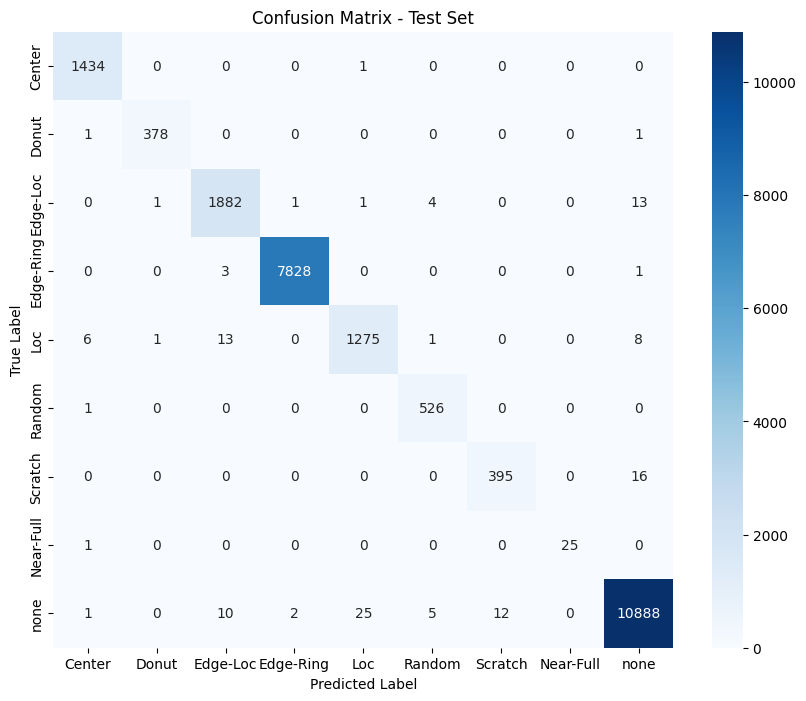

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model and test loader from the result of the last training run
model = result["model"]
train_loader, val_loader, test_loader = get_loaders() # Re-create loaders to get the test_loader
device = globals().get("device", torch.device("cpu"))

# Run evaluation on the test set to get predictions and labels
# We need to call validate or a similar function to get all_preds and all_labels
# Since eval_report already calculates these, we can modify it slightly or re-run the logic
# Let's re-run the evaluation logic for the test set to get the raw predictions and labels
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        nb = (hasattr(device, 'type') and device.type == 'cuda')
        xb = xb.to(device, non_blocking=nb)
        yb = yb.to(device, non_blocking=nb)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get the class names
IDX2NAME = {int(k): v for k, v in df_train96_balanced.groupby('failureNum')['failureType'].first().items()}
class_names = [IDX2NAME[i] for i in sorted(IDX2NAME.keys())]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()